# Tutorial 4
### Analysis and Post Processing

In [1]:
import pathlib
import subprocess
import h5py
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
# Clean up any old files
import shutil
shutil.rmtree('analysis', ignore_errors=True)

In [4]:
# Basis
xcoord = d3.Coordinate('x')
dist = d3.Distributor(xcoord, dtype=np.complex128)
xbasis = d3.Chebyshev(xcoord, 1024, bounds=(0, 300), dealias=2)

# Fields
u = dist.Field(name='u', bases=xbasis)
tau1 = dist.Field(name='tau1')
tau2 = dist.Field(name='tau2')

# Substitutions
dx = lambda A: d3.Differentiate(A, xcoord)
magsq_u = u * np.conj(u)
b = 0.5
c = -1.76

# Tau polynomials
tau_basis = xbasis.derivative_basis(2)
p1 = dist.Field(bases=tau_basis)
p2 = dist.Field(bases=tau_basis)
p1['c'][-1] = 1
p2['c'][-2] = 2

# Problem
problem = d3.IVP([u, tau1, tau2], namespace=locals())
problem.add_equation("dt(u) - u - (1 + 1j*b)*dx(dx(u)) + tau1*p1 + tau2*p2 = - (1 + 1j*c) * magsq_u * u")
problem.add_equation("u(x='left') = 0")
problem.add_equation("u(x='right') = 0")

# Solver
solver = problem.build_solver(d3.RK222)
solver.stop_sim_time = 500

# Initial conditions
x = dist.local_grid(xbasis)
u['g'] = 1e-3 * np.sin(5 * np.pi * x / 300)

2025-01-27 16:07:50,729 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


In [5]:
analysis = solver.evaluator.add_file_handler('analysis', iter=10, max_writes=400)

In [6]:
analysis.add_tasks(solver.state, layout='g')

In [7]:
# Main loop
timestep = 0.05
while solver.proceed:
    solver.step(timestep)
    if solver.iteration % 1000 == 0:
        print('Completed iteration {}'.format(solver.iteration))

Completed iteration 1000
Completed iteration 2000
Completed iteration 3000
Completed iteration 4000
Completed iteration 5000
Completed iteration 6000
Completed iteration 7000
Completed iteration 8000
Completed iteration 9000
Completed iteration 10000
2025-01-27 16:08:10,818 solvers 0/1 INFO :: Simulation stop time reached.


In [8]:
print(subprocess.check_output("find analysis | sort", shell=True).decode())

analysis
analysis/analysis_s1.h5
analysis/analysis_s2.h5
analysis/analysis_s3.h5



In [14]:
with h5py.File("analysis/analysis_s1.h5", mode='r') as file:
    # Load datasets
    mag_u = file['tasks']['<|u|>']
    t = mag_u.dims[0]['sim_time']
    # Plot data
    fig = plt.figure(figsize=(6, 4), dpi=100)
    plt.plot(t[:], mag_u[:].real)
    plt.xlabel('t')
    plt.ylabel('<|u|>')

KeyError: "Unable to synchronously open object (object '<|u|>' doesn't exist)"

In [11]:
tasks = d3.load_tasks_to_xarray("analysis/analysis_s1.h5")
fig = plt.figure(figsize=(6, 4), dpi=100)
tasks['<|u|>'].real.plot();

KeyError: '<|u|>'

<Figure size 600x400 with 0 Axes>

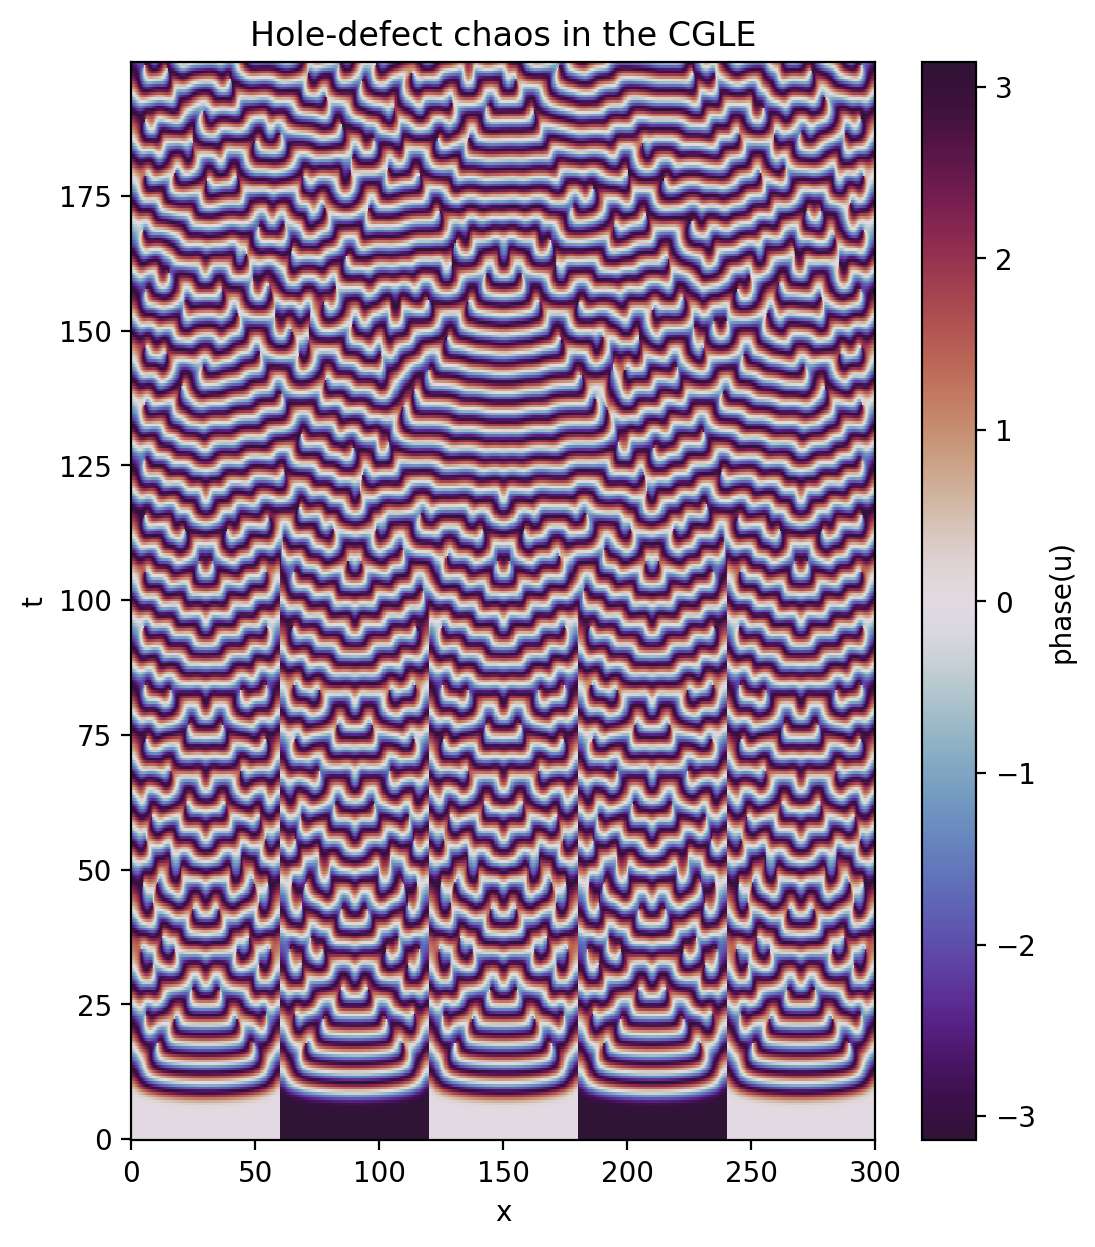

In [12]:
with h5py.File("analysis/analysis_s1.h5", mode='r') as file:
    # Load datasets
    u = file['tasks']['u']
    t = u.dims[0]['sim_time']
    x = u.dims[1][0]
    # Plot data
    u_phase = np.arctan2(u[:].imag, u[:].real)
    plt.figure(figsize=(6,7), dpi=100)
    plt.pcolormesh(x[:], t[:], u_phase, shading='nearest', cmap='twilight_shifted')
    plt.colorbar(label='phase(u)')
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title('Hole-defect chaos in the CGLE')

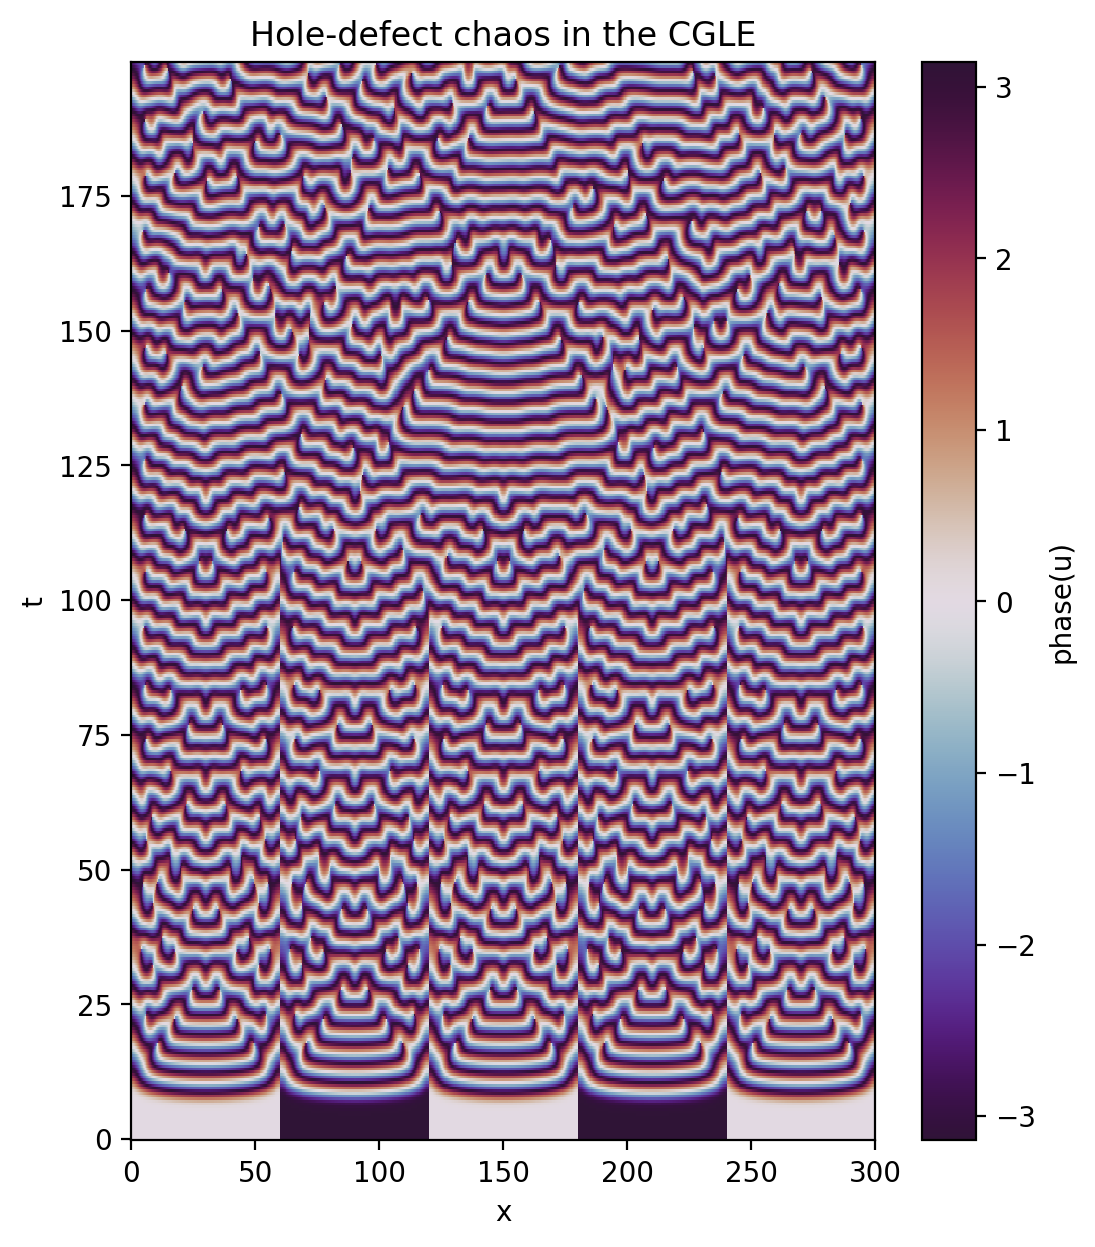

In [13]:
tasks = d3.load_tasks_to_xarray("analysis/analysis_s1.h5")
u_phase = np.arctan2(tasks['u'].imag, tasks['u'].real)
u_phase.name = "phase(u)"

plt.figure(figsize=(6,7), dpi=100)
u_phase.plot(x='x', y='t', cmap='twilight_shifted')
plt.title('Hole-defect chaos in the CGLE');